# Calculating Star Formation Rate Density

In another notebook, we calculated the Schechter function using various parameters from various literature values. We also computed the luminosity density by integrating the Schechter function. We can use a conversion factor to convert this luminosity density into the star formation rate density, such a conversion factor is usually denoted by $\kappa$. There may be different values of $\kappa$ depending upon the wavelength band of the spectrum used (i.e., IR or UV). In the present notebook, we shall use the values of this conversion factor from Madau & Dickinson (2014). Their values are,

$$\kappa_{FUV} = 2.2 \times 10^{-10} M_\odot year^{-1} L_\odot^{-1}$$ and $$\kappa_{IR} = 4.5 \times 10^{-44} M_\odot year^{-1} erg^{-1} s$$

Here, we note that the value of $\kappa_{FUV}$ is at $1500$ angstrom and it is in the units of solar luminosity, so we want to divide this value to the solar luminosity to find $\kappa_{FUV}$ in cgs units.

We first aim to use values for the Schechter function from Bouwens et al. (2012) to compute the luminosity density at various redshifts. Later, we use $\kappa_{FUV}$ (since Bouwens et al. 2012 used UV range) to measure the Star formation rate density. Finally, we shall plot the results.

After testing the code for values from Bouwens et al. (2012), we repeat the procedure for various other works for different spectral range and different redshifts with different Schechter parameters.

Let's start with the Bouwens et al. (2012) parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import astropy.units as u
import os
import utils as utl
import scipy.integrate as inte

## Best-fitted SFRD function

We also define the best fitted SFRD function from Madau & Dickinson below,

$$ \psi(z) = 0.015 \frac{(1+z)^{2.7}}{1 + [(1+z)/2.9]^{5.6}} M_\odot \ year^{-1} Mpc^{-3}$$

In [2]:
def psi_md(z):
    ab = (1+z)**2.7
    cd = ((1+z)/2.9)**5.6
    ef = 0.015*ab/(1+cd)
    return ef

## Calculation of SFRD for Bouwens et al. (2012)

Below we read all of the required parameters from the paper, and list them.

In [3]:
# Redshift
z_bou = np.array([4,5,6,7,8])

# Characteristic absolute magnitude
mst_bou = np.array([-20.98, -20.60, -20.37, -20.14, -20.10])
msterr_bou = np.array([0.10, 0.23, 0.30, 0.26, 0.52])

# Characteristic luminosity
lst_bou = np.array([])
lsterr_bou = np.array([])

for i in range(len(mst_bou)):
    mst1 = np.random.normal(mst_bou[i], msterr_bou[i], 10000)
    lst1 = utl.m_to_l_wave(mst1, 1500)
    lst_bou = np.hstack((lst_bou, np.mean(lst1)))
    lsterr_bou = np.hstack((lsterr_bou, np.std(lst1)))


# Normalisation constant
phi_bou = np.array([1.3, 1.4, 1.4, 0.86, 0.59])*0.001
phierr_bou = np.array([0.2, 0.6, 0.85, 0.545, 0.69])*0.001

# Alpha
alp_bou = np.array([-1.73, -1.79, -1.73, -2.01, -1.91])
alperr_bou = np.array([0.005, 0.12, 0.20, 0.21, 0.32])

# Dust Correction
auv_bou = np.array([0.58, 0.44, 0.20, 0.10, 0.0])

# Kappas
sol_lum = (con.L_sun*1e7).value
kap_uv = 2.2e-10/sol_lum
kap_ir = 4.5*10**(-44)

# Range of Luminosities (or absolute magnitudes) used
mags_bou = np.linspace(-24, -13, 10)
lums_bou = utl.m_to_l_wave(mags_bou, 1500)

#print(np.log10(lst_bou))
#print(np.log10(lsterr_bou))
#print(np.log10(lums_bou))

Below we present our calculation for SFRD for various redshifts ranging from $4$ to $8$ with different parameters for the Schechter function as presented in Bouwens et al. (2012). Initially, we won't consider the error propogation; later, if this goes perfect, then we'd add the error propogation.

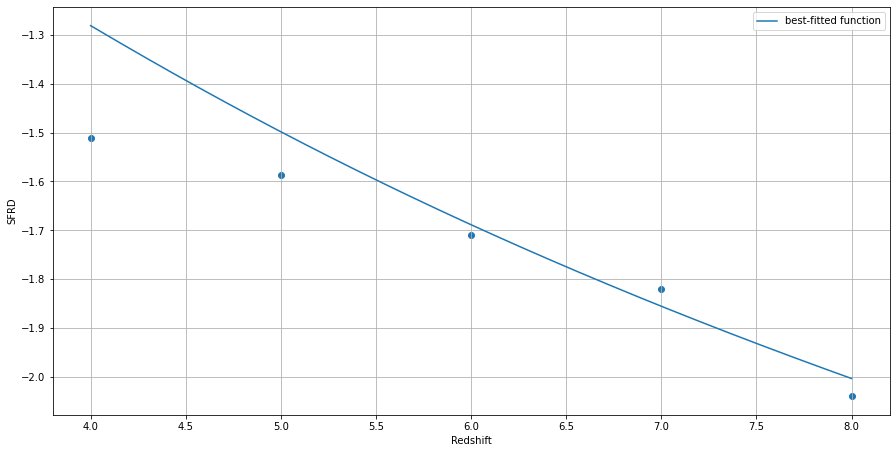

In [4]:
# Calculations without error propogation
sfrd_bou_wo = np.array([])

for i in range(len(z_bou)):
    # Defining luminosity range
    lum_range = np.linspace(0.03*lst_bou[i], np.max(lums_bou), 10000)
    # Finding the Schechter function
    sche_bou = utl.schechter(lum=lum_range, phi1=phi_bou[i], lum1=lst_bou[i], alpha=alp_bou[i])
    # Finding integration
    integral = lum_range*sche_bou
    lum_den_bou = inte.simps(integral, lum_range)
    sfrd_bou1 = lum_den_bou*kap_uv
    sfrd_bou_wo = np.hstack((sfrd_bou_wo, sfrd_bou1))

log_sfr_bou_wo = np.log10(sfrd_bou_wo)#*utl.lam_to_nu(1500))

z_all_bou = np.linspace(4,8,1000)
best_fit_sfrd_bou = np.log10(psi_md(z=z_all_bou))

plt.figure(figsize=(15,7.5))
plt.scatter(z_bou, log_sfr_bou_wo)
plt.plot(z_all_bou, best_fit_sfrd_bou, label='best-fitted function')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.legend(loc='best')
plt.grid()

It seems that the magnitude of SFRD matches with their corresponding values from Madau & Dickinson (2014) paper. We now describe the way we propogate the errors in our calculation. However, the best fit lines does not exactly follow the points; that's because we didn't apply any dust correction, which we perform below.

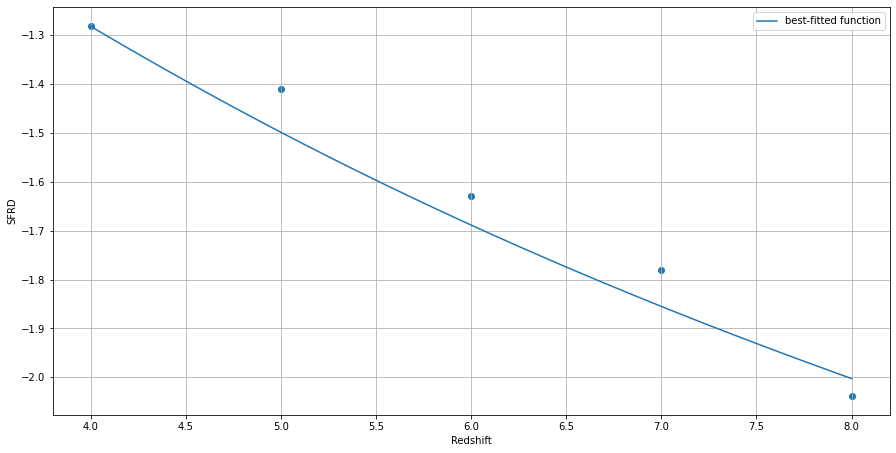

In [5]:
# Calculations without error propogation
sfrd_bou_wod = np.array([])

for i in range(len(z_bou)):
    # Defining luminosity range
    lum_range_d = np.linspace(0.03*lst_bou[i], np.max(lums_bou), 10000)
    # Finding the Schechter function
    sche_boud = utl.schechter(lum=lum_range_d, phi1=phi_bou[i], lum1=lst_bou[i], alpha=alp_bou[i])
    # Finding integration
    integral_d = lum_range_d*sche_boud
    lum_den_boud = inte.simps(integral_d, lum_range_d)
    lum_den_bou_d = lum_den_boud*(10**(0.4*auv_bou[i]))
    sfrd_bou1d = lum_den_bou_d*kap_uv
    sfrd_bou_wod = np.hstack((sfrd_bou_wod, sfrd_bou1d))

log_sfr_bou_wod = np.log10(sfrd_bou_wod)#*utl.lam_to_nu(1500))

plt.figure(figsize=(15,7.5))
plt.scatter(z_bou, log_sfr_bou_wod)
plt.plot(z_all_bou, best_fit_sfrd_bou, label='best-fitted function')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.legend(loc='best')
plt.grid()

Well, cannot say anything for sure! Let's apply for large sample size!

## Calculation of SFRD

Now we want to reproduce the same procedure we did above for other Schechter function parameters from literature. We make a dataset of the Schechter function parameters from the literature and saved it elsewhere. Below, we use these values from literature and compute SFRD as demonstrated above. We, for now, do not pay attention on the propogation of errors, which we include later.

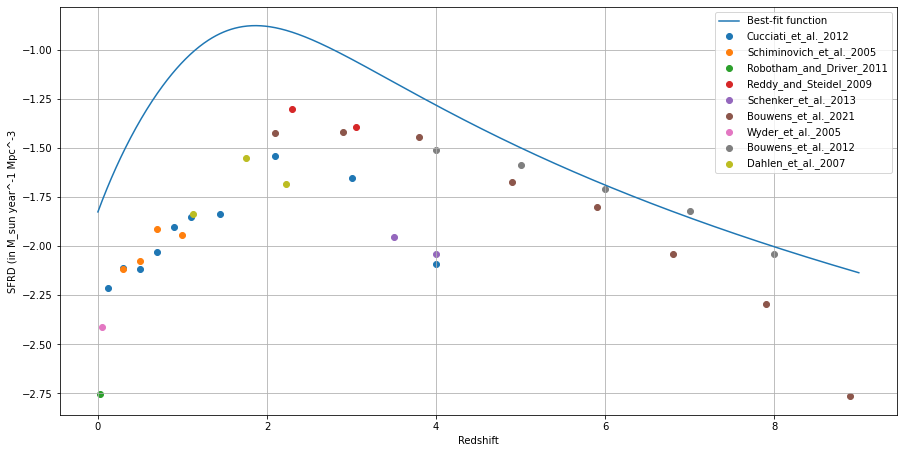

In [6]:
p1 = os.getcwd() + '/data/'
# To save results
p22 = os.getcwd() + '/Results/'
f22 = open(p22 + 'sfrd_all_wo_err.dat', 'w')
f22.write('#Name_of_the_paper\tZ_up\tZ_down\tSFRD\n')
#---------------

ls1 = os.listdir(p1)

list_uv = []
for i in range(len(ls1)):
    if ls1[i][0:7] == 'data_UV':
        list_uv.append(ls1[i])

z_all_uv = np.array([])
sfrd_all_uv = np.array([])
A_fuv = np.array([])

plt.figure(figsize=(15,7.5))

for i in range(len(list_uv)):
    z1_uv, z2_uv, mst_uv, msterr_uv, phi_uv, phierr_uv, alp_uv, alperr_uv, auv = np.loadtxt(p1 + list_uv[i], usecols=(0,1,2,3,4,5,6,7,9), unpack=True)
    ppr_n = np.loadtxt(p1 + list_uv[i], usecols=8, dtype=str, unpack=True)
    # Converting Magnitudes into luminosities
    lst_uv = np.array([])
    lsterr_uv = np.array([])
    if type(mst_uv) == np.float64:
        lngth = 1
        z1_uv, z2_uv, mst_uv, msterr_uv, phi_uv, phierr_uv, alp_uv, alperr_uv, ppr_n = np.array([z1_uv]), np.array([z2_uv]), np.array([mst_uv]), np.array([msterr_uv]), np.array([phi_uv]), np.array([phierr_uv]), np.array([alp_uv]), np.array([alperr_uv]), np.array([ppr_n])
    else:
        lngth = len(mst_uv)
    for k in range(lngth):
        mst1 = np.random.normal(mst_uv[k], msterr_uv[k], 10000)
        lst1 = utl.m_to_l_wave(mst1, 1500)
        lst_uv = np.hstack((lst_uv, np.mean(lst1)))
        lsterr_uv = np.hstack((lsterr_uv, np.std(lst1)))
    # Calculating SFRD
    sfrd_uv_wo = np.array([])
    for j in range(len(z1_uv)):
        sfr2_wo = utl.sfrd_wo_err(lum=lums_bou, lum1=lst_uv[j], phi1=phi_uv[j], alpha=alp_uv[j], kappa=kap_uv)
        sfrd_uv_wo = np.hstack((sfrd_uv_wo, sfr2_wo))
        f22.write(ppr_n[0] + '\t' + str(z1_uv[j]) + '\t' + str(z2_uv[j]) + '\t' + str(sfr2_wo) + '\n')
    log_sfr_uv_wo = np.log10(sfrd_uv_wo)#*utl.lam_to_nu(1500))
    # Plotting the results
    zcen = (z1_uv + z2_uv)/2
    A_fuv = np.hstack((A_fuv, auv))
    z_all_uv = np.hstack((z_all_uv, zcen))
    sfrd_all_uv = np.hstack((sfrd_all_uv, log_sfr_uv_wo))
    plt.scatter(zcen, log_sfr_uv_wo, label=ppr_n[0])

znew = np.linspace(0,9,1000)
psi1 = psi_md(znew)
psi2 = np.log10(psi1)

f22.close()

plt.plot(znew, psi2, label='Best-fit function')

plt.xlabel('Redshift')
plt.ylabel('SFRD (in M_sun year^-1 Mpc^-3')
plt.grid()
plt.legend(loc='best')

It is evident that the best fit curve is not following the observations --- we need to apply the dust correction to it, which we do below.

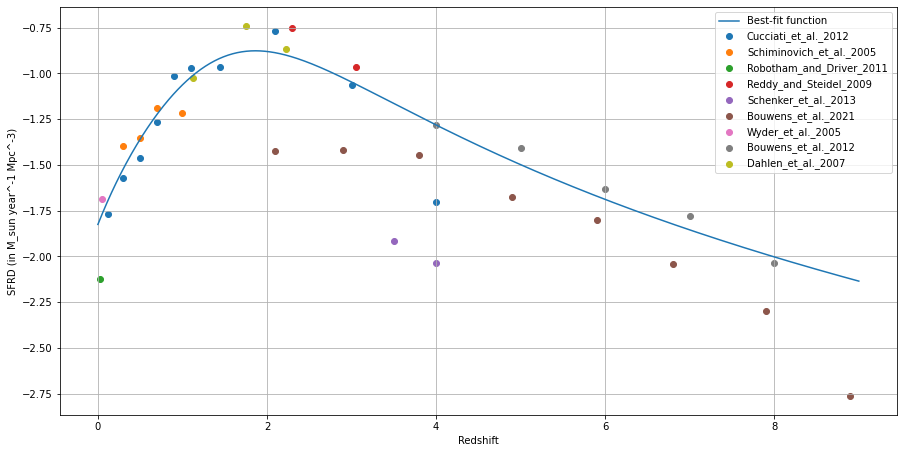

In [7]:
dust_cor_sfrd_uv = np.array([])
plt.figure(figsize=(15,7.5))

for i in range(len(list_uv)):
    z1_uv, z2_uv, mst_uv, msterr_uv, phi_uv, phierr_uv, alp_uv, alperr_uv, auv = np.loadtxt(p1 + list_uv[i], usecols=(0,1,2,3,4,5,6,7,9), unpack=True)
    ppr_n = np.loadtxt(p1 + list_uv[i], usecols=8, dtype=str, unpack=True)
    # Converting Magnitudes into luminosities
    lst_uv = np.array([])
    lsterr_uv = np.array([])
    if type(mst_uv) == np.float64:
        lngth = 1
        z1_uv, z2_uv, mst_uv, msterr_uv, phi_uv, phierr_uv, alp_uv, alperr_uv, ppr_n, auv = np.array([z1_uv]), np.array([z2_uv]), np.array([mst_uv]), np.array([msterr_uv]), np.array([phi_uv]), np.array([phierr_uv]), np.array([alp_uv]), np.array([alperr_uv]), np.array([ppr_n]), np.array([auv])
    else:
        lngth = len(mst_uv)
    for k in range(lngth):
        mst1 = np.random.normal(mst_uv[k], msterr_uv[k], 10000)
        lst1 = utl.m_to_l_wave(mst1, 1500)
        lst_uv = np.hstack((lst_uv, np.mean(lst1)))
        lsterr_uv = np.hstack((lsterr_uv, np.std(lst1)))
    # Calculating SFRD
    sfrd_uv_wod = np.array([])
    for j in range(len(z1_uv)):
        sfr2_wo = utl.sfrd_wo_err(lum=lums_bou, lum1=lst_uv[j], phi1=phi_uv[j], alpha=alp_uv[j], kappa=kap_uv, Auv=auv[j])
        sfrd_uv_wod = np.hstack((sfrd_uv_wod, sfr2_wo))
    log_sfr_uv_wod = np.log10(sfrd_uv_wod)#*utl.lam_to_nu(1500))
    # Plotting the results
    zcen = (z1_uv + z2_uv)/2
    dust_cor_sfrd_uv = np.hstack((dust_cor_sfrd_uv, log_sfr_uv_wod))
    plt.scatter(zcen, log_sfr_uv_wod, label=ppr_n[0])


znew = np.linspace(0,9,1000)
psi1 = psi_md(znew)
psi2 = np.log10(psi1)

plt.plot(znew, psi2, label='Best-fit function')

plt.xlabel('Redshift')
plt.ylabel('SFRD (in M_sun year^-1 Mpc^-3)')
plt.grid()
plt.legend(loc='best')

Well, it seems okay!

## IR Luminosities

Now, we turn our attention towards the IR part; it seems that they don't use the Schechter functions to compute the luminosity densities; instead they use some different functions stated below:

$$\phi(L) d\log{L} = \phi_* \left( \frac{L}{L_*} \right)^{1-\alpha} \exp{\left( -\frac{1}{2\sigma^2} \left\{ \log{\left[1 + \frac{L}{L_*} \right]}\right\}^2 \right)} d\log L$$

If we take $X=\log L$, then we can write above equation as follows,

$$\phi(X) dX = \frac{\ln 10 \ \phi_* \ 10^{\alpha X}}{10^{(1-\alpha)\log L_*}} \exp{\left( -\frac{1}{2\sigma^2} \left\{\log{\left[ 1 + 10^{X - \log L_*} \right]}\right\}^2 \right)} dX$$

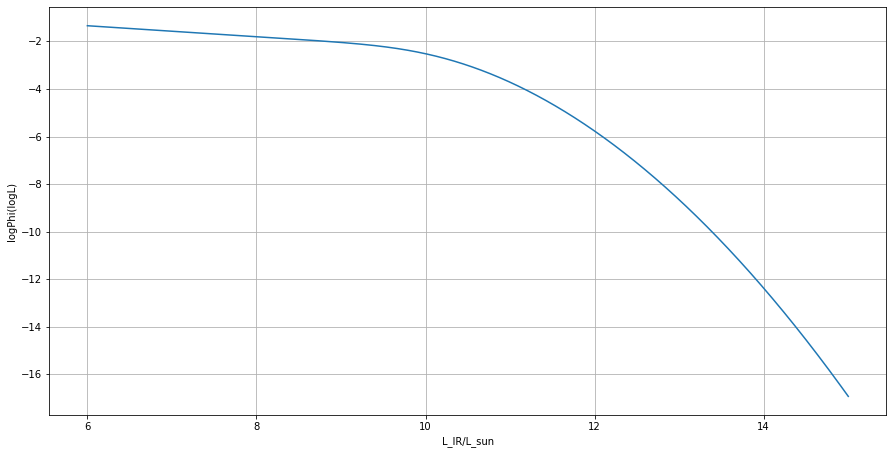

In [8]:
def sandage(lums9, alp9, phi9, sig9, lst9):
    ab = 1 + (lums9/lst9)
    bc = np.log10(ab)
    cd = bc**2
    ef = -cd/(2*sig9*sig9)
    gh = np.exp(ef)
    xy = (lums9/lst9)**(1-alp9)
    return xy*phi9*gh

ls2 = os.listdir(p1)
ls_ir = []

for i in range(len(ls2)):
    if ls2[i][0:7] == 'data_IR':
        ls_ir.append(ls2[i])

z1_ir, z2_ir, alp_ir, alperr_ir, lst_ir, lsterr_ir, sig_ir, sigerr_ir, phi_ir, phierr_ir = np.loadtxt(p1 + ls_ir[0], usecols=(0,1,2,3,4,5,6,7,8,9), unpack=True)
ppr_n1 = np.loadtxt(p1 + ls_ir[0], usecols=10, dtype=str, unpack=True)

lums_ir1 = np.logspace(6, 15, 10000)*con.L_sun.value*1e7

san23 = sandage(lums9=lums_ir1, alp9=alp_ir, phi9=phi_ir, sig9=sig_ir, lst9=lst_ir)
plt.figure(figsize=(15,7.5))
plt.plot(np.log10(lums_ir1/(con.L_sun.value*1e7)), np.log10(san23))
plt.xlabel('L_IR/L_sun')
plt.ylabel('logPhi(logL)')
plt.grid()

## Computing IR SFRD for Takeuchi et al. (2003)

In [9]:
lums_inte = np.logspace(np.log10(0.03*lst_ir), np.max(np.log10(lums_ir1)), 100000)
san34 = sandage(lums9=lums_inte, alp9=alp_ir, phi9=phi_ir, sig9=sig_ir, lst9=lst_ir)
sam12 = san34*lums_inte
sam_inte1 = inte.simps(y=sam12, x=np.log10(lums_inte))

print('Luminosity density is (in cgs): {:.2e}'.format(sam_inte1))

sfrd_12 = kap_ir*sam_inte1

print('log(SFRD) (in M_sun year-1): {:.2e}'.format(np.log10(sfrd_12)))

Luminosity density is (in cgs): 2.36e+41
log(SFRD) (in M_sun year-1): -1.97e+00


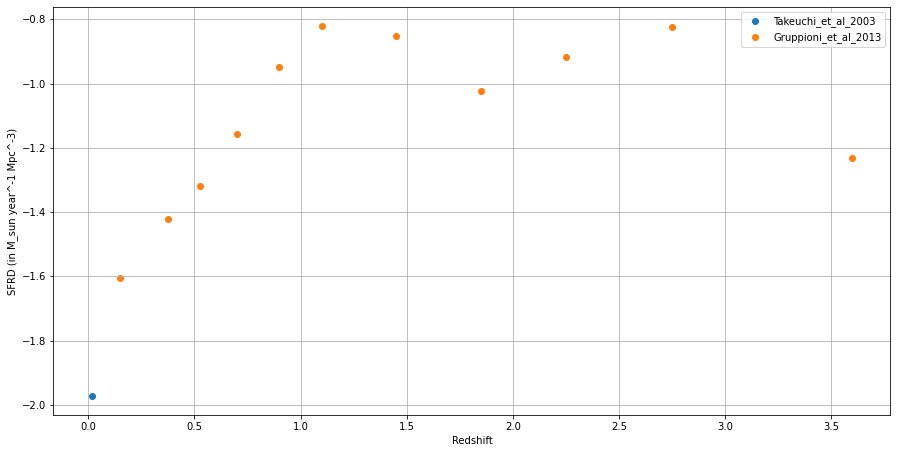

In [10]:
plt.figure(figsize=(15,7.5))

sfrd_all_ir = np.array([])
z_all_ir = np.array([])

for i in range(len(ls_ir)):
    z1_ir, z2_ir, alp_ir, alperr_ir, lst_ir, lsterr_ir, sig_ir, sigerr_ir, phi_ir, phierr_ir = np.loadtxt(p1 + ls_ir[i], usecols=(0,1,2,3,4,5,6,7,8,9), unpack=True)
    ppr_n1 = np.loadtxt(p1 + ls_ir[i], usecols=10, dtype=str, unpack=True)
    if type(alp_ir) == np.float64:
        z1_ir, z2_ir, alp_ir, alperr_ir, lst_ir, lsterr_ir, sig_ir, sigerr_ir, phi_ir, phierr_ir, ppr_n1 = np.array([z1_ir]), np.array([z2_ir]), np.array([alp_ir]), np.array([alperr_ir]), np.array([lst_ir]), np.array([lsterr_ir]), np.array([sig_ir]), np.array([sigerr_ir]), np.array([phi_ir]), np.array([phierr_ir]), np.array([ppr_n1])
    sfrd_ir12 = np.array([])
    for j in range(len(z1_ir)):
        nor_lum = np.logspace(np.log10(0.03*lst_ir[j]), np.max(np.log10(lums_ir1)), 10000)
        nor_sc1 = sandage(nor_lum, alp9=alp_ir[j], phi9=phi_ir[j], sig9=sig_ir[j], lst9=lst_ir[j])
        nor_sc = nor_lum*nor_sc1#/phi1
        rho_nor = inte.simps(nor_sc, np.log10(nor_lum))
        sfrd_ir = rho_nor*kap_ir
        sfrd_ir12 = np.hstack((sfrd_ir12, sfrd_ir))
    zcen1 = (z1_ir + z2_ir)/2
    log_sfrd_ir12 = np.log10(sfrd_ir12)
    plt.scatter(zcen1, log_sfrd_ir12, label=ppr_n1[i])
    z_all_ir = np.hstack((z_all_ir, zcen1))
    sfrd_all_ir = np.hstack((sfrd_all_ir, log_sfrd_ir12))

plt.xlabel('Redshift')
plt.ylabel('SFRD (in M_sun year^-1 Mpc^-3)')
plt.grid()
plt.legend(loc='best')

## Plotting both values on the same plot

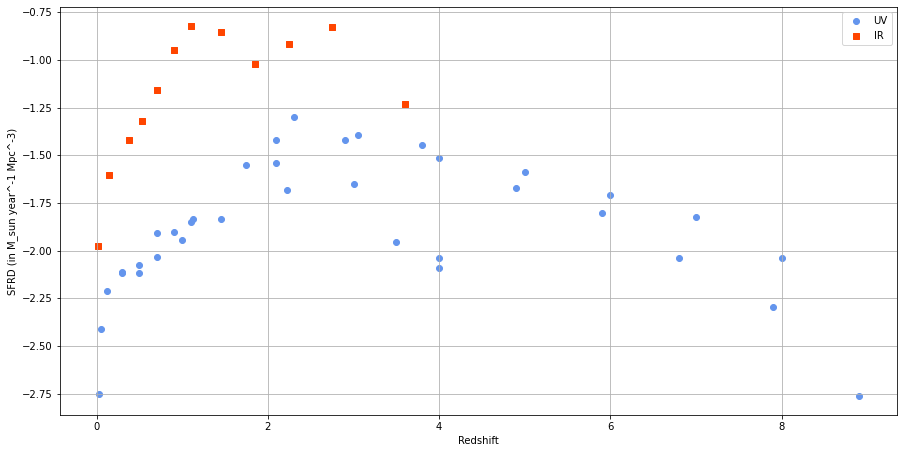

In [11]:
plt.figure(figsize=(15,7.5))
plt.scatter(z_all_uv, sfrd_all_uv, marker='o', c='cornflowerblue', label='UV')
plt.scatter(z_all_ir, sfrd_all_ir, marker='s', c='orangered', label='IR')
plt.xlabel('Redshift')
plt.ylabel('SFRD (in M_sun year^-1 Mpc^-3)')
plt.grid()
plt.legend(loc='best')

Now, after applying dust correction to UV luminosities...

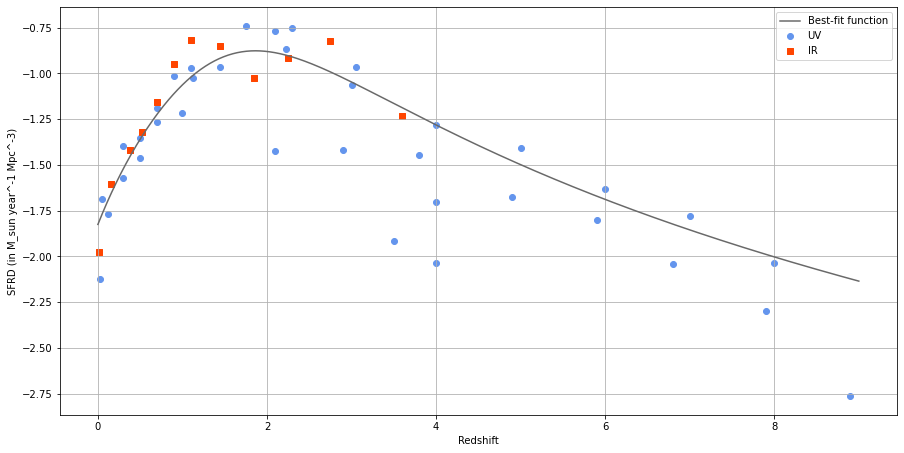

In [12]:
plt.figure(figsize=(15,7.5))
plt.plot(znew, psi2, label='Best-fit function', c='dimgrey')
plt.scatter(z_all_uv, dust_cor_sfrd_uv, marker='o', c='cornflowerblue', label='UV')
plt.scatter(z_all_ir, sfrd_all_ir, marker='s', c='orangered', label='IR')
plt.xlabel('Redshift')
plt.ylabel('SFRD (in M_sun year^-1 Mpc^-3)')
plt.grid()
plt.legend(loc='best')